## Prepare data for MDD and imaging - Volve data

In [2]:
# env: UD_RM

import warnings
warnings.filterwarnings('ignore')


import numpy as np
import matplotlib.pyplot as plt
import segyio
from scipy.signal import filtfilt


from udrm.segyshot import SegyShot
from udrm.wavefieldsepforp import wavefield_sepforp
from udrm.wavefieldsep import wavefield_separation
from udrm.wavsep_utils import *

## Data loading

In [3]:
velfile = '../dataset/ST10010/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'
inputfile = '../dataset/ST10010/ST10010_1150780_40203.sgy'
filepath = '../dataset/Data/Volve/'
f = segyio.open(inputfile, ignore_geometry=True)
fv = segyio.open(velfile)

In [4]:
# axes, the position of in-line (109), cross-line (241) and z-axis (226)
ilvel, xlvel, zvel = fv.ilines, fv.xlines,  fv.samples

# Velocity model
vmodtr = segyio.collect(fv.trace[:])
vmod = segyio.cube(velfile)
print('the shape of velocity model is', np.shape(vmod))

# Velocity model (il,xl,z) (109,241,226)
num_il=np.shape(ilvel)[0]

the shape of velocity model is (109, 241, 226)


In [5]:
# ilsvel, xlsvel are the grid position of in-line (109) and cross-line (241)
ilsvel, xlsvel = fv.attributes(segyio.TraceField.INLINE_3D)[:], fv.attributes(segyio.TraceField.CROSSLINE_3D)[:]

scvel = fv.header[0][segyio.TraceField.SourceGroupScalar]
if (scvel<0):
    scvel=1./abs(scvel)
xvel, yvel = scvel * fv.attributes(segyio.TraceField.CDP_X)[:] , scvel * fv.attributes(segyio.TraceField.CDP_Y)[:]
# the size of xvel and yvel is the size of xlvel.size multiply ilvel.size

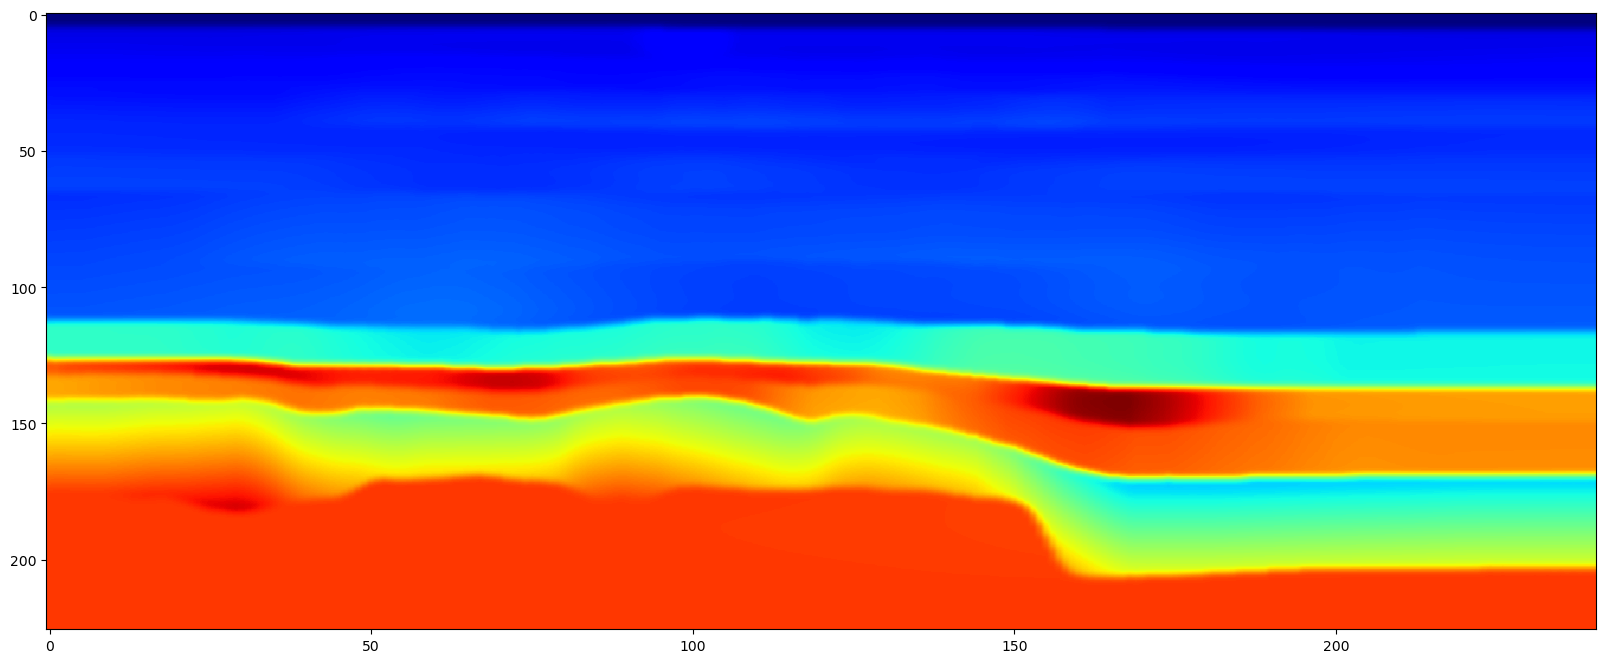

In [6]:
plt.figure(figsize=(20, 8))
plt.imshow(vmod[50].T, cmap='jet')
plt.axis('tight');

In [7]:
# Trace header
print('First trace header', f.header[0])
print('GroupX from first trace header', f.header[0][segyio.TraceField.GroupX])

First trace header {TRACE_SEQUENCE_LINE: 1, TRACE_SEQUENCE_FILE: 28801, FieldRecord: 1000, TraceNumber: 1, EnergySourcePoint: 1000, CDP: 10205120, CDP_TRACE: 0, TraceIdentificationCode: 1, NSummedTraces: 0, NStackedTraces: 0, DataUse: 1, offset: 3109, ReceiverGroupElevation: -1010, SourceSurfaceElevation: -2, SourceDepth: 62, ReceiverDatumElevation: 0, SourceDatumElevation: 0, SourceWaterDepth: 1060, GroupWaterDepth: 1010, ElevationScalar: -10, SourceGroupScalar: -10, SourceX: 4280572, SourceY: 64774885, GroupX: 4311640, GroupY: 64776128, CoordinateUnits: 1, WeatheringVelocity: 0, SubWeatheringVelocity: 0, SourceUpholeTime: 0, GroupUpholeTime: 0, SourceStaticCorrection: 0, GroupStaticCorrection: 0, TotalStaticApplied: 0, LagTimeA: 0, LagTimeB: 0, DelayRecordingTime: 0, MuteTimeStart: 0, MuteTimeEND: 0, TRACE_SAMPLE_COUNT: 5000, TRACE_SAMPLE_INTERVAL: 2000, GainType: 1, InstrumentGainConstant: 6, InstrumentInitialGain: 0, Correlated: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, Swee

In [8]:
# EBCDIC header containing textual information of the data
print(segyio.tools.wrap(f.text[0]))  
print(f.bin)
print('JobID from binary header: ', f.bin[segyio.BinField.JobID])

C 1 CLIENT: STATOIL           COMPANY: RESERVOIR EXPLORATION TECHNOLOGY
C 2 AREA: VOLVE NORWAY BLOCK 15/9                SURVEY: ST10010
C 3 SWATH:  11                             VESSELS:M/V VIKLAND, M/V SANCO
SPIRITC 4 RCV LINE: 1150780    RCVR RANGE: 1239-1717
C 5 DATA-SET: NAV MERGE   TRACES PER RECORD: 240 X 4   SEQ: 094-133
C 6 RECORDING FORMAT: IEEE SEG-Y           FORMAT THIS REEL: SEG-Y 3592
C 7 SAMPLE CODE: FLOATING PT               PROCESSED: 03/11/2010
C 8 ACQ. GEOM: 8 ROLL 8  INLINE SWATH      LINE PREFIX: ST10010
C 9 INSTRUMENT: VECTORSEIS OCEAN BOTTOM    RECORDING SYSTEM DELAY: 0 MS
C10 RECORDING FILTER: 1.5/6-187/260MIN PHS DESCRIPTION: HZ/DB PER OCTAVE
C11 NO OF RECEIVER LINES/SWATH: 8          RECEIVER LINE SEPARATION: 400/200M
C12 ACTIVE CABLE LENGTH: 5975M             RCVRS / RCV LINE 240 X 4
C13 NO OF SOURCES:  2                      SOURCE SEPARATION: 50M
C14 RECEIVER INTERVAL: 25M                 SHOT INTERVAL: 25M, FLIP/FLOP
C15 DATUM: ED50, 31N  SPHEROID: INT. 

## Data and velocity saving for imaging

Local regular axis:
 ox=0.000000, dx=49.793406 nx=241
 oy=-0.000000, dy=49.540976 ny=109


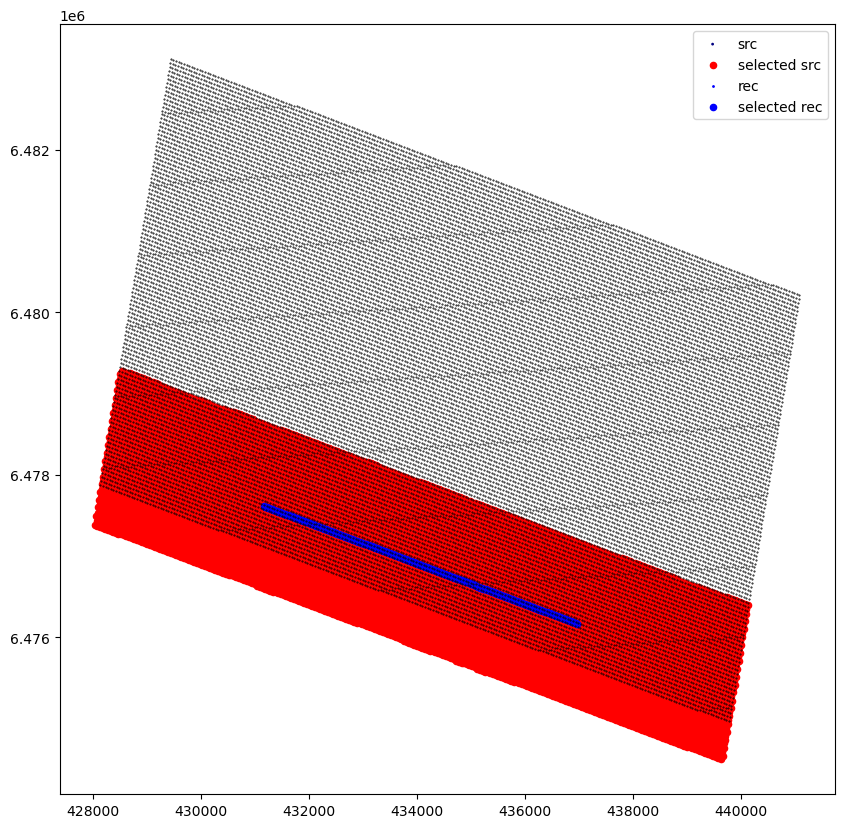

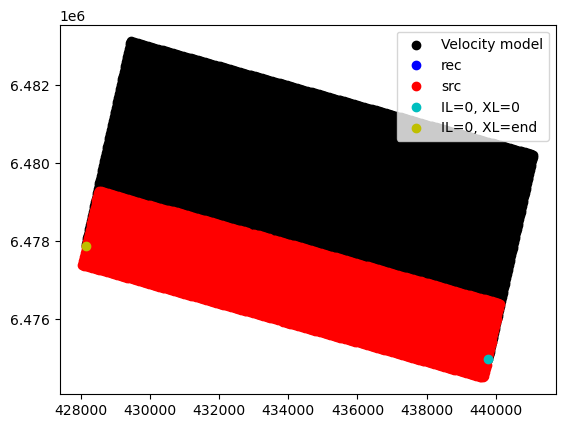

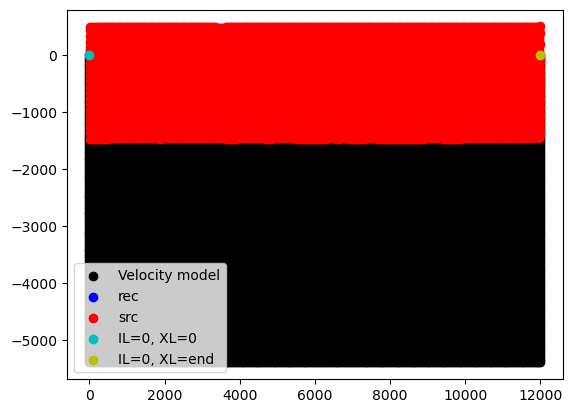

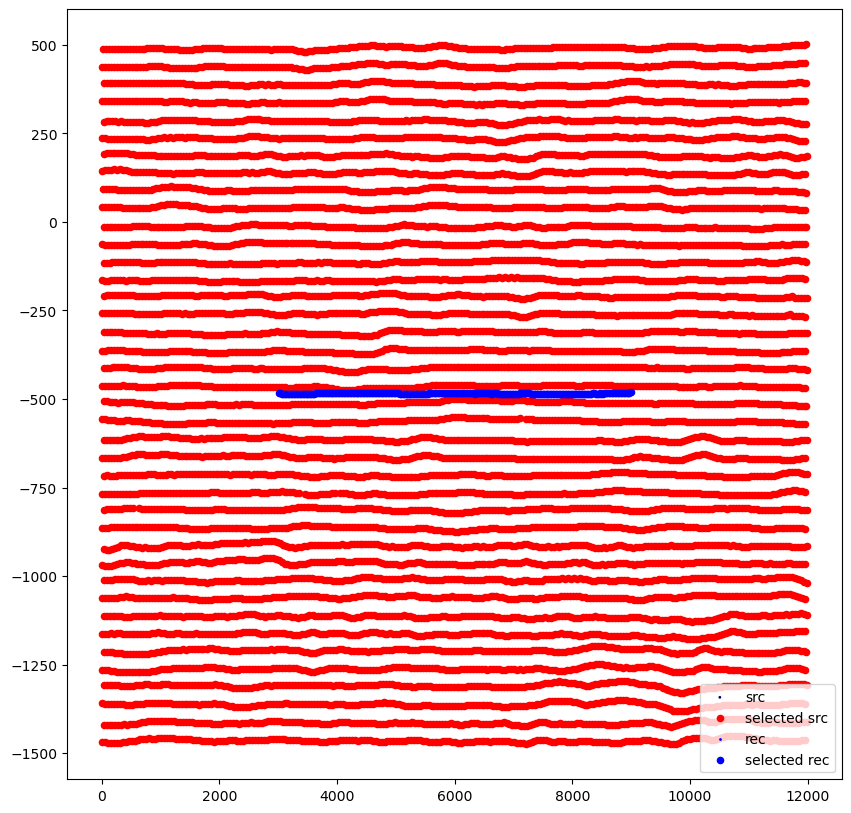

In [9]:
# Shot gather
sg = SegyShot(inputfile, components=['P', 'VZ', 'VX', 'VY'])
sg.interpret()
sg.showgeometry()
plt.scatter(xvel, yvel, c='k', s=.2)

_,_,_,_, (xvel_local, yvel_local) = sg.rotategeometry(velfile=velfile, plotflag=1)
sg.showgeometry(local=True)

sg.showgeometry()
plt.scatter(xvel[:10000], yvel[:10000], c='k', s=.2)


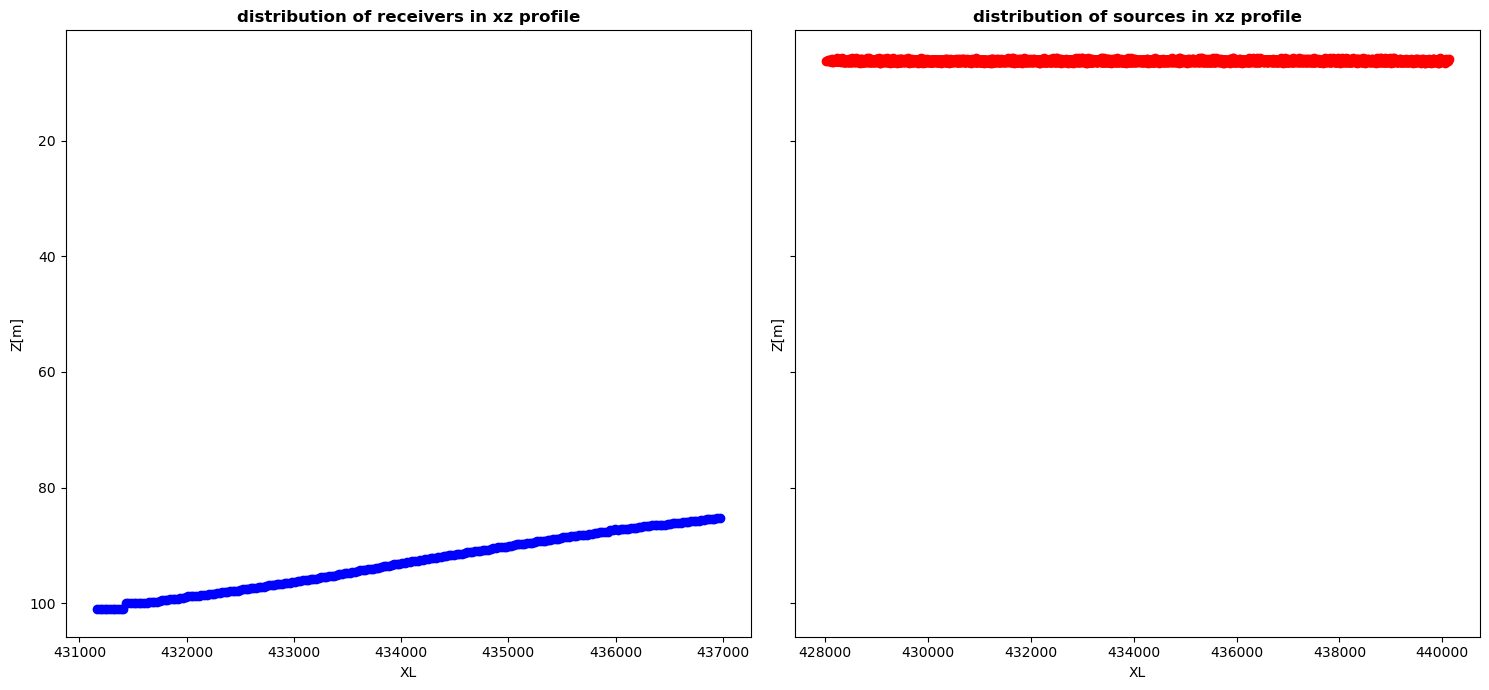

In [10]:
recx=sg.recx
recy=sg.recy
recz=sg.recz
srcx=sg.srcx
srcy=sg.srcy
srcz=sg.srcz
num_rec=np.shape(recx)
num_src=np.shape(srcx)

fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
axs[0].scatter(recx,recz,c='b')
axs[0].set_title('distribution of receivers in xz profile', fontweight='bold')
axs[0].set_xlabel('XL')
axs[0].set_ylabel('Z[m]')
axs[0].invert_yaxis()
axs[0].axis('tight')

axs[1].scatter(srcx,srcz,c='r')
axs[1].set_title('distribution of sources in xz profile', fontweight='bold')
axs[1].set_xlabel('XL')
axs[1].set_ylabel('Z[m]')
axs[1].axis('tight')
plt.tight_layout();

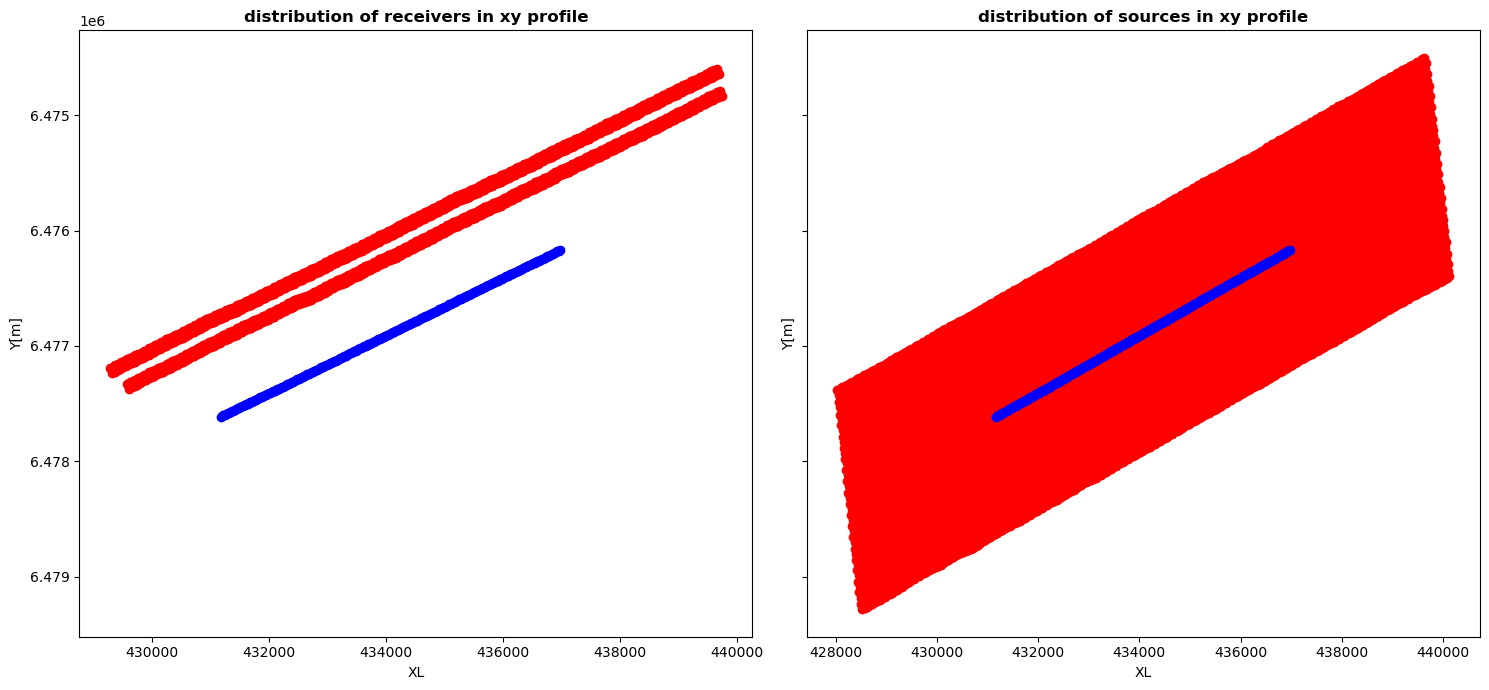

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

axs[0].scatter(srcx[50:900],srcy[50:900],c='r')
axs[0].scatter(recx,recy,c='b')
axs[0].set_title('distribution of receivers in xy profile', fontweight='bold')
axs[0].set_xlabel('XL')
axs[0].set_ylabel('Y[m]')
axs[0].invert_yaxis()
axs[0].axis('tight')

axs[1].scatter(srcx,srcy,c='r')
axs[1].scatter(recx,recy,c='b')
axs[1].set_title('distribution of sources in xy profile', fontweight='bold')
axs[1].set_xlabel('XL')
axs[1].set_ylabel('Y[m]')
axs[1].axis('tight')
plt.tight_layout();

## Parameters

In [12]:
# Geometry
# irecin, irecend = 30, 210

ishotc = 5519
ishotin, ishotend = ishotc-240, ishotc+240
irecin, irecend = 0, 240

In [13]:
# Corrupted traces
clip = 1e5
izmin = 200
nmed = 7
threshmax = 1.4
threshmin = 0.4
filtkind = 'low'
filttype = 'fk' # butter or fk

if filtkind=='high':
    # Filtering and Calibration (high freq)
    fmax = 110.
    nlpf = 5
    twin = [0.01, 0.07]
    nfilt = 15 
elif filtkind=='mid':
    # Filtering and Calibration (mid freq)
    fmax = 90.
    nlpf = 5
    nfilt = 11
    twin = [0.03, 0.08]
elif filtkind=='low':
    # Filtering and Calibration (low freq) - currently used!
    fmax = 35.
    nlpf = 5
    nfilt = 11
    twin = [0.03, 0.08]

In [14]:
# fk filter
critical = 0.95
ntapermask = 5
ntapersmooth = 100

In [15]:
# Separation parameters
vel_dir = 1500.
vwater = 1480.

# water
vel_sep=1500 # velocity at separation level
rho_sep=1000 # density at separation level


## Testing processing

In [16]:
# Raw data
ishotc = 5530
shot = sg.get_shotgather(ishotc)

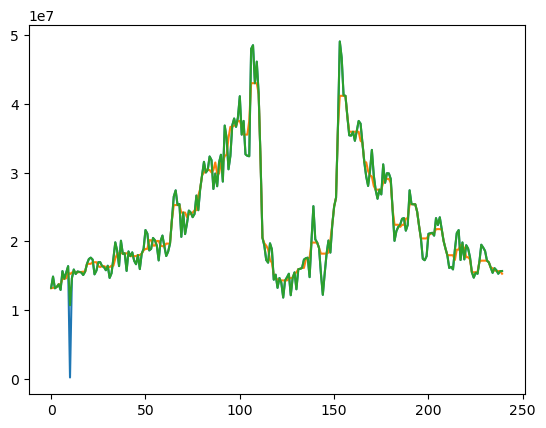

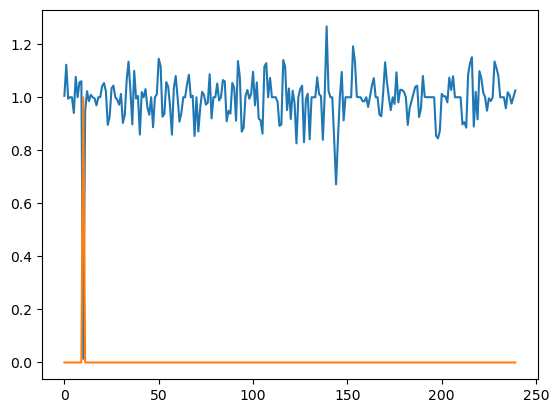

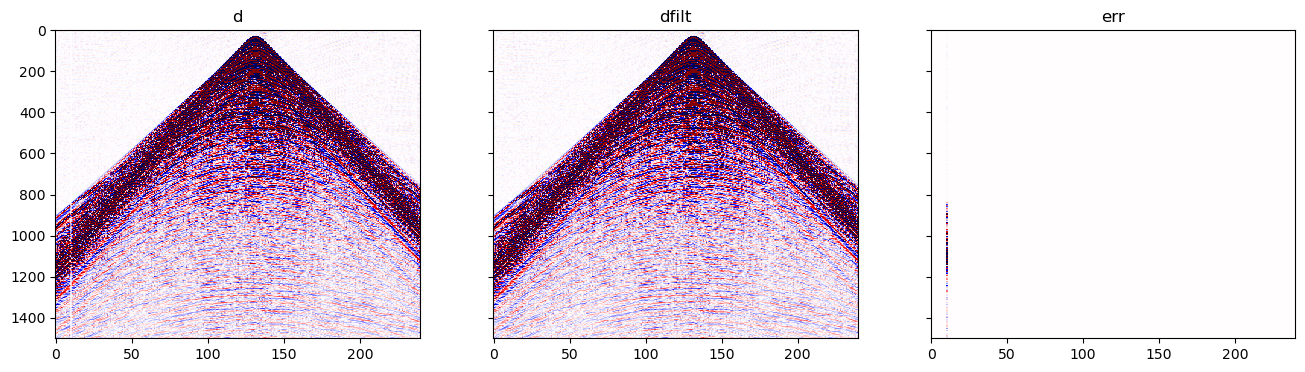

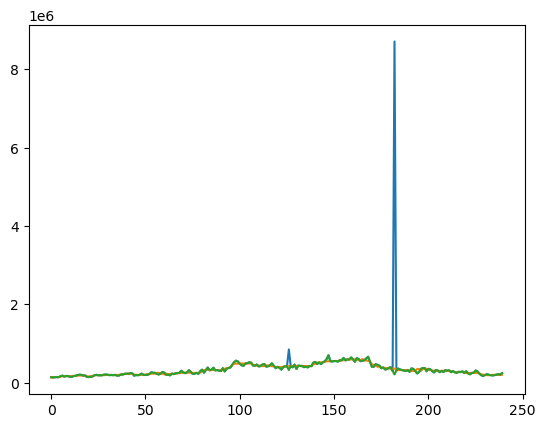

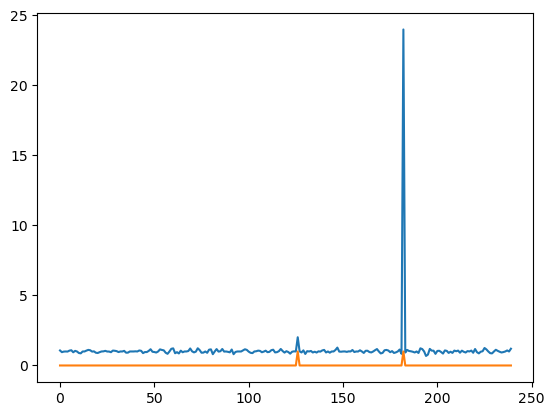

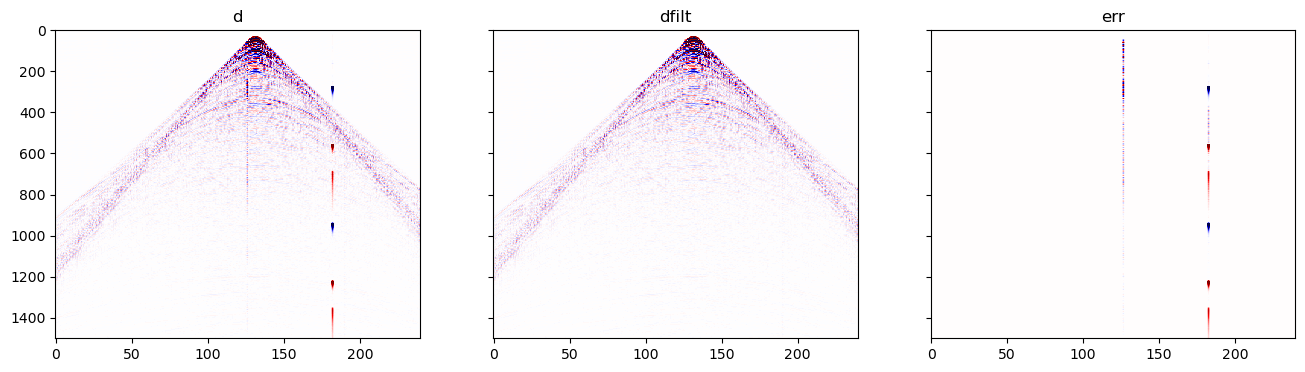

In [17]:
# Fix corruption
clip=1e5
izmin = 200
nmed = 7
threshmax = 1.4
threshmin = 0.4

shot['P'], corrupted = \
    fix_corrupt(shot['P'], izmin, nmed, threshmax, threshmin, plotflag=True, clip=clip, zmax=1500);

shot['VZ'], corrupted = \
    fix_corrupt(shot['VZ'], izmin, nmed, threshmax, threshmin, plotflag=True, clip=clip, zmax=1500);

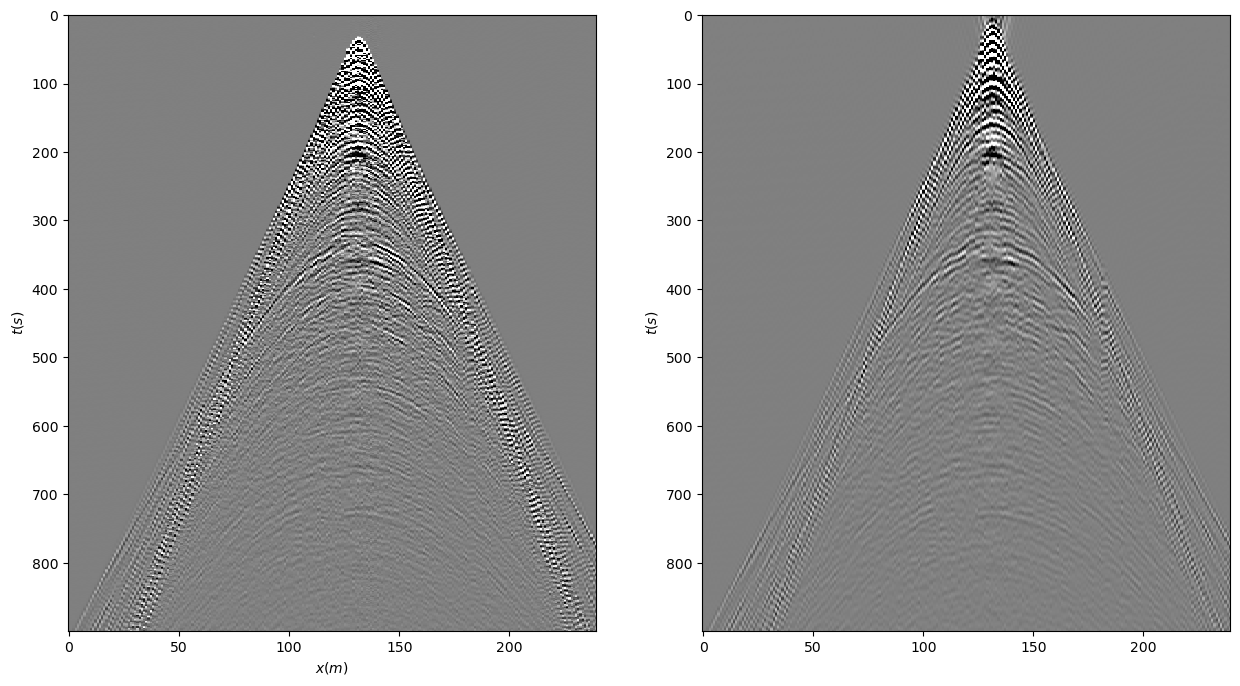

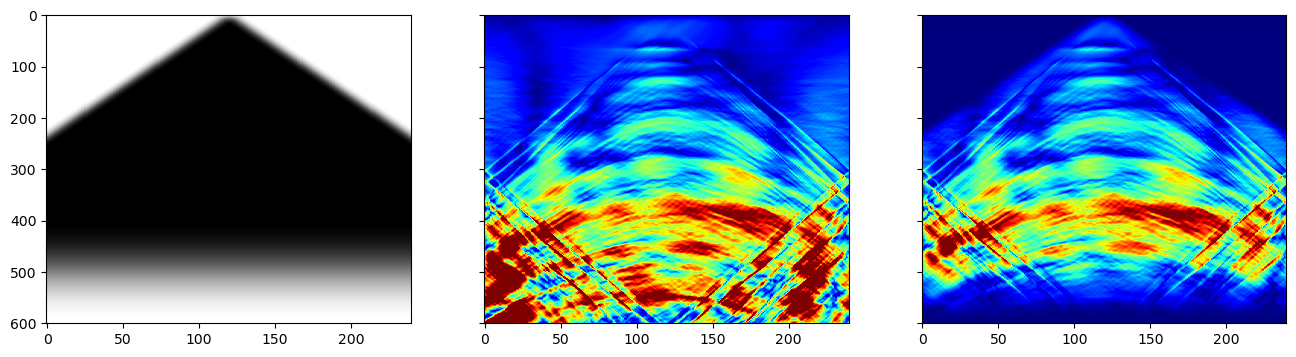

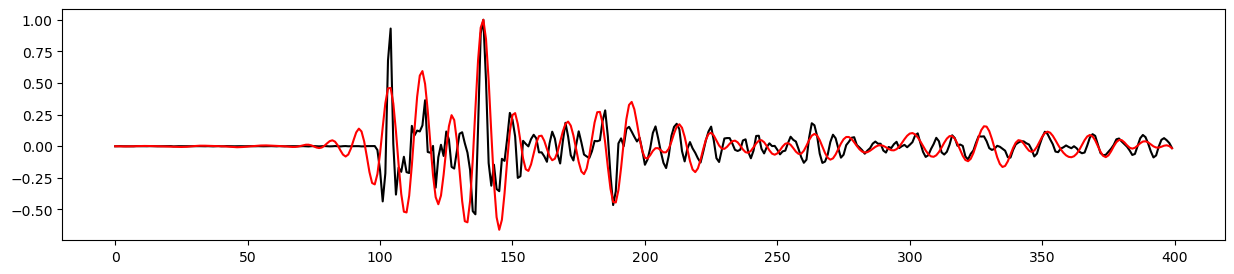

In [18]:
# Filtering
nrec = len(sg.selected_rec)
dr = np.mean(np.diff(sg.recx[sg.selected_rec]))

nffts = (nrec, sg.nt)
FFTop = FFT2D(dims=[nrec, sg.nt], 
              nffts=nffts, sampling=[dr, sg.dt])

pfilt, P, Pfilt, Mask, imask = fk_filter(shot['VZ'], nrec, sg.nt, dr, sg.dt, 
                                         FFTop, fmax=50, critical=1.3, vel_sep=1500, 
                                         ntapersmooth=100, ntapermask=20)

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].imshow(shot['VZ'][:, :900].T, aspect='auto', interpolation='nearest',
              vmin=-5e6/100, vmax=5e6/100, cmap='gray')
axs[0].set_xlabel(r'$x(m)$')
axs[0].set_ylabel(r'$t(s)$')
axs[1].imshow(pfilt[:, :900].T, aspect='auto', interpolation='nearest',
              vmin=-5e6/100, vmax=5e6/100, cmap='gray')
axs[1].set_ylabel(r'$t(s)$')

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 4))
axs[0].imshow(np.fft.fftshift(np.abs(Mask).T, axes=1)[:sg.nt//2], vmin=0, vmax=1, cmap='gray_r')
axs[0].axis('tight')
axs[1].imshow(np.fft.fftshift(np.abs(P).T, axes=1)[:sg.nt//2], 
              vmin=0, vmax=0.5*np.abs(P).max(), cmap='jet')
axs[1].axis('tight')
axs[2].imshow(np.fft.fftshift(np.abs(Pfilt).T, axes=1)[:sg.nt//2], 
              vmin=0, vmax=0.5*np.abs(P).max(), cmap='jet')
axs[2].axis('tight')
axs[2].set_ylim(imask+100, 0)

plt.figure(figsize=(15, 3))
plt.plot(shot['VZ'][nrec//2, :400]/np.abs(shot['VZ'][nrec//2, :400]).max(), 'k')
plt.plot(pfilt[nrec//2, :400]/np.abs(pfilt[nrec//2, :400]).max(), 'r');

## seclecting sources and receivers

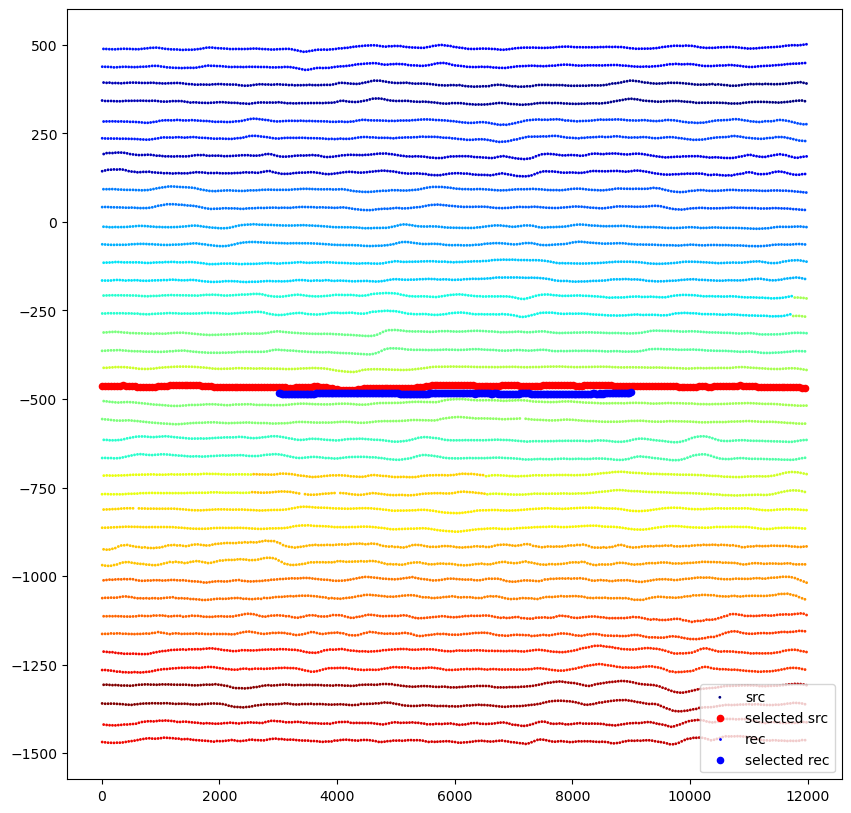

In [19]:
ilveldata = 9999 # selected inline

ishotc = 5520
startshot=ishotc-240
endshot=ishotc+240
jshot = 2
nshots = endshot - startshot

vmoddata = vmod[np.where(ilvel==ilveldata)[0]]

sg.selectrecs(irecin, irecend, plotflag=False)
sg.selectsrcs(startshot, endshot, jshot, plotflag=False)
sg.showgeometry(local=True)
plt.scatter(xvel_local[np.where(ilsvel == ilveldata)], yvel_local[np.where(ilsvel == ilveldata)], c='k', s=10)

In [20]:
shot_test = sg.get_shotgather(ishotc)
p_test = shot['P']
vz_test = shot['VZ']

print('the shape of shot gather p is', np.shape(p_test))
print('the maximum value of shot gather p is', np.max(p_test))
print('the shape of shot gather vz is', np.shape(vz_test))
print('the maximum value of shot gather vz is', np.max(vz_test))

the shape of shot gather p is (240, 5000)
the maximum value of shot gather p is 407563550.0
the shape of shot gather vz is (240, 5000)
the maximum value of shot gather vz is 3578389.5


In [21]:
nshots = len(sg.selected_src)
nrecs = len(sg.selected_rec)
pfilt2d = np.zeros((nshots, nrecs, sg.nt))
vzfilt2d = np.zeros((nshots, nrecs, sg.nt))
vzcalib2d  = np.zeros((nshots, nrecs, sg.nt))
pup2d = np.zeros((nshots, nrecs, sg.nt))
pdown2d  = np.zeros((nshots, nrecs, sg.nt))
p_zo = np.zeros((nshots, sg.nt))
vz_zo = np.zeros((nshots, sg.nt))
pup_zo = np.zeros((nshots, sg.nt))
pdown_zo = np.zeros((nshots, sg.nt))
rec_x_zo = np.zeros(nshots)
rec_y_zo = np.zeros(nshots)

In [29]:
print('nshots = ', nshots)
print('nrecs = ', nrecs)
print('nt = ', sg.nt)
print('dt = ', sg.dt)

nshots =  240
nrecs =  240
nt =  5000
dt =  0.002


In [30]:
# processing data
fmax = 30
    
for i, shot in enumerate(range(startshot, endshot, jshot)):
    pfilt2d[i], vzfilt2d[i], vzcalib2d[i], pup2d[i], pdown2d[i], _, p_zo[i], vz_zo[i], pup_zo[i], pdown_zo[i], rec_x_zo[i], rec_y_zo[i] = \
        calibrated_wavefield_separation(sg, shot, 
                                        izmin=izmin, nmed=nmed, threshmax=threshmax, threshmin=threshmin, #fix_corrupt
                                        fmax=fmax, nlpf=nlpf, filttype=filttype, # low_pass_filter, but not used now
                                        vwater=vel_dir, nfilt=nfilt, twin=twin, 
                                        vel_sep=vel_sep, rho_sep=rho_sep, # calibration
                                        critical=critical, ntapermask=ntapermask, # fk filter
                                        plotflag=False)
    


In [31]:
rho_sep = 1000      # density at receiver

vel = vmoddata[0]
t = sg.t
z = zvel
x = np.linspace(0, 12000, xlvel.shape[0], dtype=int)

r = np.zeros((2,nrecs))
r[0] = sg.recx_local
r[1] = sg.recz

s = np.zeros((2,nshots))
for i, shot in enumerate(range(startshot, endshot, jshot)):
    s[0,i] = sg.srcx_local[shot]
    s[1,i] = sg.srcz[shot]

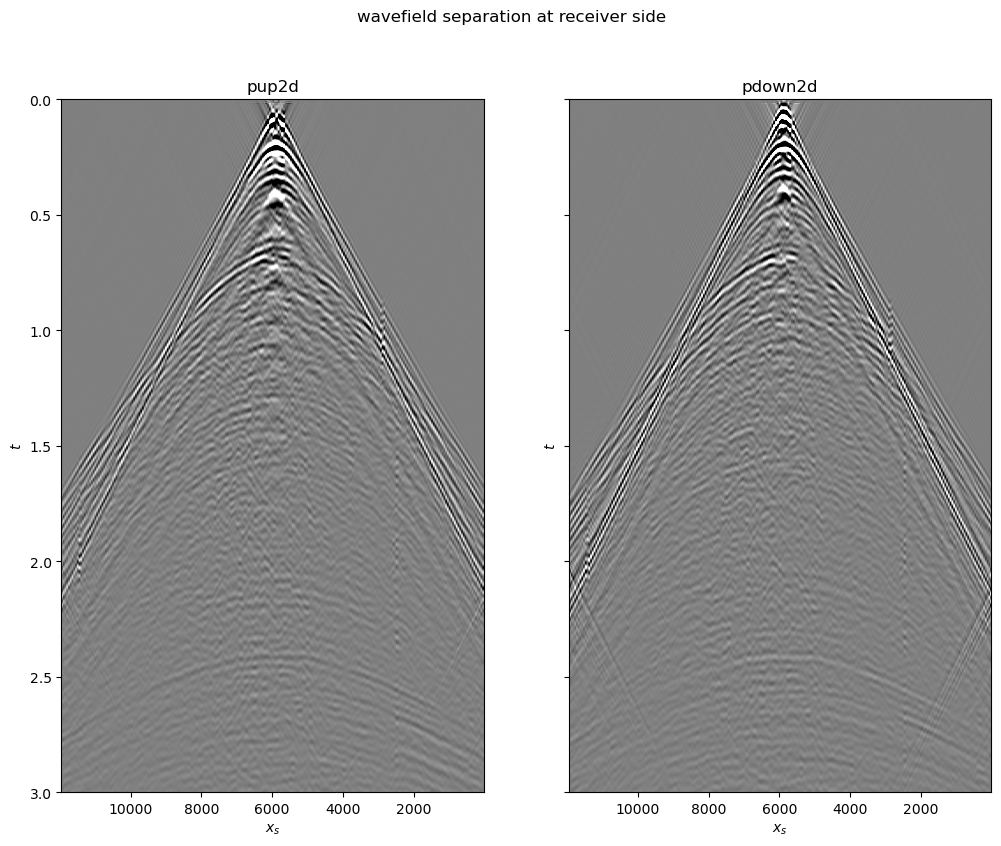

In [32]:
clip = 0.01
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
fig.suptitle('wavefield separation at receiver side')
axs[0].imshow(pup2d[nshots//2].T, cmap='gray', vmin=-clip*np.abs(pup2d).max(), 
              vmax=clip*np.abs(pup2d).max(), extent=(s[0,0], s[0,-1], t[-1], t[0]))
axs[0].set_title('pup2d'), axs[0].set_xlabel(r'$x_s$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[1].imshow(pdown2d[nshots//2].T, cmap='gray', vmin=-clip*np.abs(pdown2d).max(), 
              vmax=clip*np.abs(pdown2d).max(), extent=(s[0,0], s[0,-1], t[-1], t[0]))
axs[1].set_title('pdown2d'), axs[1].set_xlabel(r'$x_s$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(3,0);

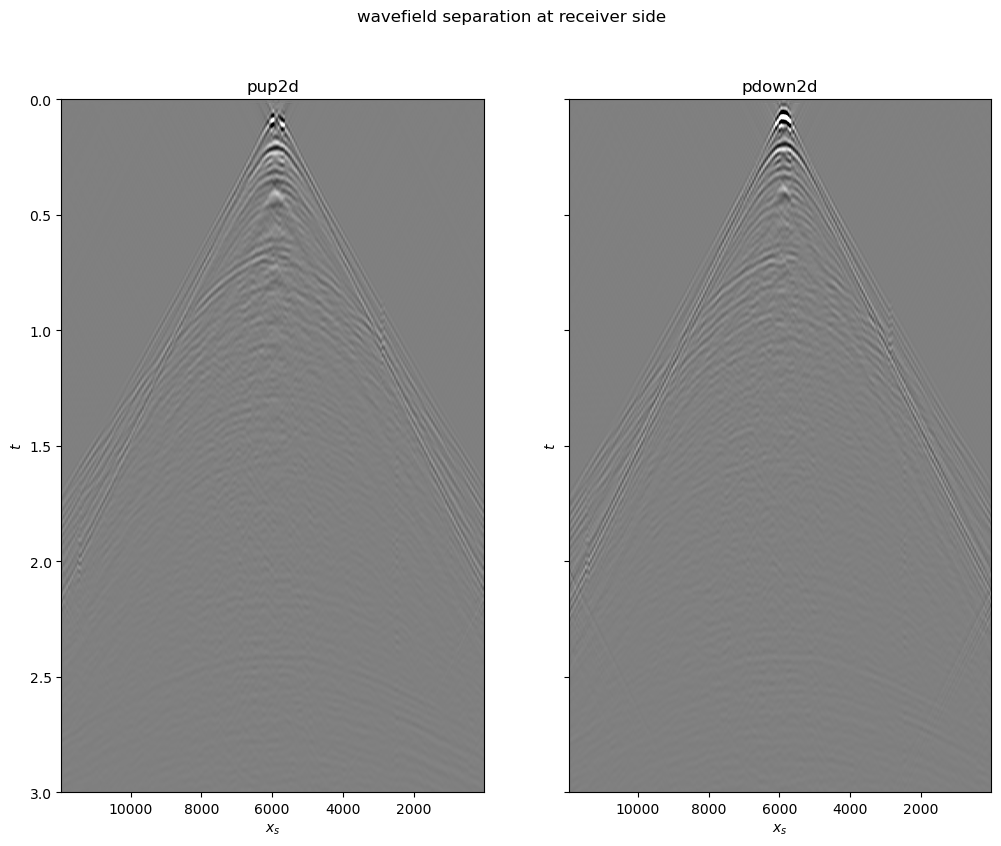

In [33]:
clip = 0.05
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
fig.suptitle('wavefield separation at receiver side')
axs[0].imshow(pup2d[nshots//2].T, cmap='gray', vmin=-clip*np.abs(pup2d).max(), 
              vmax=clip*np.abs(pup2d).max(), extent=(s[0,0], s[0,-1], t[-1], t[0]))
axs[0].set_title('pup2d'), axs[0].set_xlabel(r'$x_s$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[1].imshow(pdown2d[nshots//2].T, cmap='gray', vmin=-clip*np.abs(pdown2d).max(), 
              vmax=clip*np.abs(pdown2d).max(), extent=(s[0,0], s[0,-1], t[-1], t[0]))
axs[1].set_title('pdown2d'), axs[1].set_xlabel(r'$x_s$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(3,0);

In [34]:
np.savez("../dataset/volve_processed_withdir_fmax30.npz", p=pfilt2d, vz=vzfilt2d, vel = vel, rho=rho_sep, r=r, s=s, t=t, x=x, z=z)